<a href="https://colab.research.google.com/github/CoolCodeMan/intro2LT/blob/lauri/pytorch-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [294]:
import warnings
warnings.filterwarnings('ignore')

# Download data

In [295]:
!wget -q -O anger-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/train.tsv
!wget -q -O anger-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/test.tsv
!wget -q -O anger-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/anger-annotation/dev.tsv

!wget -q -O joy-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/train.tsv
!wget -q -O joy-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/test.tsv
!wget -q -O joy-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/dev.tsv

# import python libraries

- numpy
- pandas
- pytorch
- scikit
- matplotlib

In [296]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from scipy.sparse import *
import sklearn.utils
import matplotlib.pyplot as plt

# Set up functions

- **shuffle** shuffles pandas dataframe
- **make_labels** takes in pandas dataframe and transforms it into tensor
- **create_dataset** takes anger and joy files, opens them into pandas dataframe and changing labels not-joy and not-anger into neutral
- **create_dataset_and_testset** takes in pandas dataframes and tranforms them into pytorch tensor
- **score** takes in model and tensors, scoring them
- **torch_shuffle** -- incomplete

In [297]:
def shuffle(data):
  data = sklearn.utils.shuffle(data)
  data.reset_index(inplace=True, drop=True)
  return data

In [298]:
def make_labels(labels):
  y = []
  for i in labels:
    if i == 'joy':
      y.append([1,0,0])
    elif i == 'anger':
      y.append([0,1,0])
    elif i == 'neutral':
      y.append([0,0,1])
  y = torch.tensor(y).float()
  return y

In [299]:
def create_dataset(angerpath, joypath):
  anger = pd.read_csv(angerpath, error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')
  joy= pd.read_csv(joypath, error_bad_lines=False, header=0, names=['emotion','text'], sep='\t')

  df = pd.concat([joy, anger])
  df['emotion'].replace({'not-joy':'neutral', 'not-anger':'neutral'}, inplace=True)
  df = shuffle(df)

  return df

In [300]:
def create_dataset_and_testset(pandas_dataset, vectorizer):

  feature_matrix = vectorizer.transform(pandas_dataset['text'])
  mat = feature_matrix.astype('float').toarray()
  X = torch.from_numpy(mat)
  y = make_labels(pandas_dataset['emotion'])

  return X, y

In [301]:
def score(model, dataset, labels, dataset_size=2024):
  total = 0
  for i in range(dataset_size):
    pred = model(dataset[i].float())
    n1 = pred.detach().cpu().numpy().argmax()
    n2 = labels[i].detach().cpu().numpy().argmax()
    if n2 == n1:
      total += 1
    
  return total/dataset_size*100

In [302]:
def torch_shuffle(df, vectorizer):
  df = shuffle(df)
  X, y = create_dataset_and_testset(df, vectorizer)
  return X, y

# Initialize data

In [303]:
dataset = create_dataset('/content/anger-train.tsv', '/content/joy-train.tsv')
vectorizer=CountVectorizer(analyzer='word', ngram_range=(1,1))
vectorizer.fit(dataset['text'])
dataset_train, labels_train = create_dataset_and_testset(dataset, vectorizer)

In [304]:
dataframe_dev = create_dataset('/content/anger-dev.tsv', '/content/joy-dev.tsv')
dataset_dev, labels_dev = create_dataset_and_testset(dataframe_dev, vectorizer)

In [305]:
dataframe_test = create_dataset('/content/anger-test.tsv', '/content/joy-test.tsv')
dataset_test, labels_test = create_dataset_and_testset(dataframe_test, vectorizer)

# Setup pytorch device

In [306]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [307]:
dataset_train = dataset_train.to(device)
labels_train = labels_train.to(device)

dataset_dev = dataset_dev.to(device)
labels_dev = labels_dev.to(device)

dataset_test = dataset_test.to(device)
labels_test = labels_test.to(device)

# Init neural network

In [308]:
class Net(nn.Module):
  def __init__(self, size):
    super(Net, self).__init__()

    self.fc1 = nn.Linear(size, 100)
    self.fc2 = nn.Linear(100, 3)

  def forward(self, X):

    out = self.fc1(X)
    out = torch.relu(out)

    out = self.fc2(out)

    return out

# Setup neural network, loss function and optimizer

In [309]:
vocab_size = dataset_train.shape[1]
model = Net(vocab_size)

loss_function = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.4)

accuracy = []
losses = []

model = model.to(device)
loss_function = loss_function.to(device)

# Train model

In [310]:
for epoch in range(50):
  print('epoch ', epoch, ' loss ', round(running_loss,3))
  running_loss = 0.0

  for i in range(2025):    
    optimizer.zero_grad()

    out = model(dataset_train[i].float())
    loss = loss_function(out, labels_train[i])
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
        accuracy.append(score(model, dataset_train[:50], labels_train[:50], 50))
        losses.append(running_loss/100)
        running_loss = 0.0

epoch  0  loss  0.769
epoch  1  loss  4.758
epoch  2  loss  4.741
epoch  3  loss  4.72
epoch  4  loss  4.684
epoch  5  loss  4.658
epoch  6  loss  4.648
epoch  7  loss  4.602
epoch  8  loss  4.566
epoch  9  loss  4.368
epoch  10  loss  4.328
epoch  11  loss  4.182
epoch  12  loss  3.993
epoch  13  loss  3.88
epoch  14  loss  3.502
epoch  15  loss  3.382
epoch  16  loss  3.01
epoch  17  loss  2.634
epoch  18  loss  2.621
epoch  19  loss  2.567
epoch  20  loss  2.464
epoch  21  loss  2.251
epoch  22  loss  2.14
epoch  23  loss  2.232
epoch  24  loss  1.972
epoch  25  loss  1.869
epoch  26  loss  1.745
epoch  27  loss  1.656
epoch  28  loss  1.582
epoch  29  loss  1.423
epoch  30  loss  1.188
epoch  31  loss  1.341
epoch  32  loss  1.09
epoch  33  loss  1.135
epoch  34  loss  1.005
epoch  35  loss  0.863
epoch  36  loss  0.858
epoch  37  loss  0.882
epoch  38  loss  0.883
epoch  39  loss  0.86
epoch  40  loss  0.795
epoch  41  loss  0.696
epoch  42  loss  0.852
epoch  43  loss  0.79
epoch

# SCORES

In [311]:
print('Train ', round(score(model, dataset_train, labels_train, dataset_size=2025), 3))
print('Devel ', round(score(model, dataset_dev, labels_dev, dataframe_dev.shape[0]), 3))
print('Test ', round(score(model, dataset_test, labels_test, dataframe_test.shape[0]), 3))

Train  99.309
Devel  80.0
Test  81.25


# Statistics

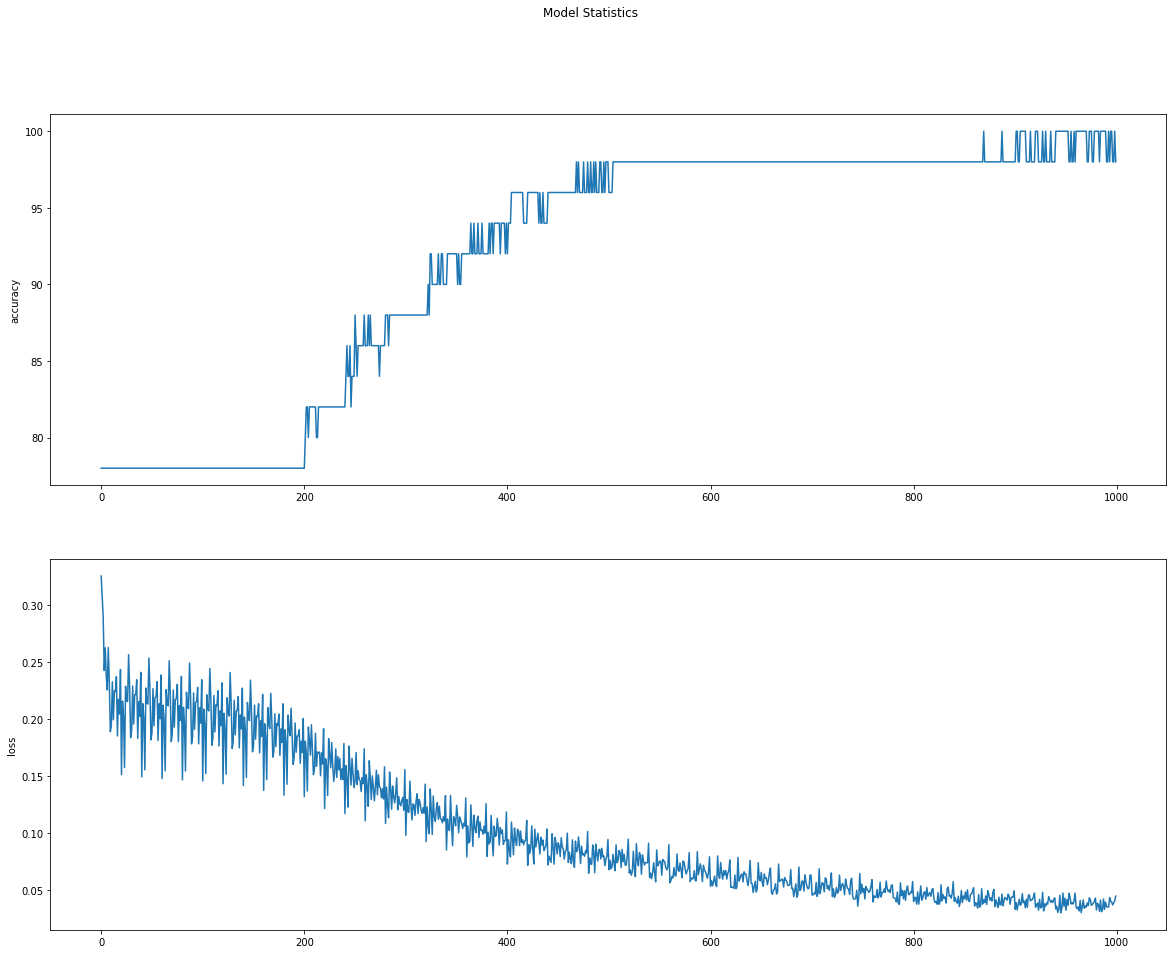

In [312]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))

fig.suptitle('Model Statistics')

ax1.plot(accuracy)
ax1.set_ylabel('accuracy')

ax2.plot(losses)
ax2.set_ylabel('loss')

plt.show()